In [ ]:
import os
import sys
import json
import torch
from torch import nn, optim
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
import pandas as pd
import numpy as np

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

### Load data

In [ ]:
root_dir = '/content/drive/MyDrive/Deep_learning_course/Project/'
project_dir = os.path.join(root_dir, 'FastRCNN/')

In [ ]:
path_to_external_folder = os.path.join(root_dir, 'data/')
path_to_zip_folder = os.path.join(path_to_external_folder, 'Archive_classification.zip')
indicator_name = 'face_data.csv'
indicator_path = os.path.join(project_dir, 'data', 'train', indicator_name)
current_folder_path = '/content/localdata/'
indicator_local = os.path.join(current_folder_path, indicator_name)
!unzip -q $path_to_zip_folder -d $current_folder_path
!cp -r $indicator_path $indicator_local

In [ ]:
class FastrcnnDataset(Dataset):
  def __init__(self, root: str, subdir: str, transform: None|object=None):
    """

    """
    super().__init__()
    self.root_dir = root
    self.subdir = subdir
    self.transform = transform


    self.data = (
      pd.read_csv(self.root_dir + 'face_data.csv')
      .assign(
        file_path=lambda k: self.root_dir + '/' + self.subdir + '/' + k.gender + '/' + k.file_name,
        class_ = lambda k: np.where(k.gender == "Female faces", 1, 2)
      )
      [['file_path', 'x_min', 'y_min', 'x_max', 'y_max', 'class_']]
      .to_numpy()
    )



  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path, x_min, y_min, x_max, y_max, class_ = self.data[idx]

    img = read_image(img_path)

    # image height and width
    a_h, a_w = img.shape[1:]

    # resize coordinates
    x_min = int(x_min * a_w)
    y_min = int(y_min * a_h)
    x_max = int(x_max * a_w)
    y_max = int(y_max * a_h)

    # define box
    box = torch.tensor([[x_min, y_min, x_max, y_max]])

    # define labels
    labels = torch.tensor([class_])

    # compute area of bounding box
    area = (x_max - x_min) * (y_max - y_min)

    # iscrowd
    iscrowd = torch.tensor([0])

    # create target tensor
    img = tv_tensors.Image(img)

    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes([[x_min, y_min, x_max, y_max]], format="XYXY", canvas_size=(a_h, a_w))
    target["labels"] = labels
    target["image_id"] = idx
    target["area"] = torch.tensor([area])
    target["iscrowd"] = iscrowd

    if self.transform:
      img, target = self.transform(img, target)

    return img, target


In [ ]:
dataset = FastrcnnDataset(root=current_folder_path, subdir='Archive_joint', transform=None)

In [ ]:
dataset[2100]

(Image([[[227, 226, 225,  ..., 162, 162, 162],
         [226, 226, 225,  ..., 162, 162, 162],
         [226, 226, 225,  ..., 163, 162, 162],
         ...,
         [ 78,  83,  82,  ..., 161, 160, 159],
         [ 82,  83,  78,  ..., 161, 161, 161],
         [ 85,  83,  75,  ..., 162, 162, 162]],
 
        [[228, 227, 226,  ..., 155, 155, 155],
         [227, 227, 226,  ..., 155, 155, 155],
         [227, 227, 226,  ..., 156, 155, 155],
         ...,
         [ 83,  88,  87,  ..., 148, 147, 146],
         [ 87,  88,  83,  ..., 148, 148, 148],
         [ 90,  88,  80,  ..., 149, 149, 149]],
 
        [[222, 221, 220,  ..., 147, 147, 147],
         [221, 221, 220,  ..., 147, 147, 147],
         [219, 219, 218,  ..., 148, 147, 147],
         ...,
         [ 87,  92,  91,  ..., 132, 131, 130],
         [ 91,  92,  87,  ..., 132, 132, 132],
         [ 94,  92,  84,  ..., 133, 133, 133]]], dtype=torch.uint8, ),
 {'boxes': BoundingBoxes([[149, 130, 348, 367]], format=BoundingBoxFormat.XYXY, ca

In [ ]:
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.RandomRotation(degrees=15))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
dataset = FastrcnnDataset(root=current_folder_path, subdir='Archive_joint', transform=get_transform(train=True))

In [ ]:
dataset[0]

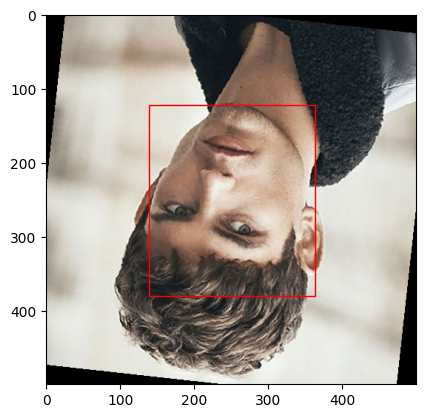

In [ ]:
# prompt: print the image with its bounding box using Rectangle

# import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get a sample from the dataset
image, target = dataset[2100]

# Create a figure and axes
fig, ax = plt.subplots(1)

# Show the image
ax.imshow(image.permute(1, 2, 0))

# Create a Rectangle patch
x_min, y_min, x_max, y_max = target["boxes"][0].tolist()
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the axes
ax.add_patch(rect)

# Show the plot
plt.show()


### Define model

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(num_classes=2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 202MB/s]


In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3
# use our dataset and defined transformations
dataset = FastrcnnDataset(root=current_folder_path, subdir='Archive_joint', transform=get_transform(train=True))
dataset_test = FastrcnnDataset(root=current_folder_path, subdir='Archive_joint', transform=get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [   0/1796]  eta: 1:57:02  lr: 0.000010  loss: 1.5193 (1.5193)  loss_classifier: 1.4227 (1.4227)  loss_box_reg: 0.0640 (0.0640)  loss_objectness: 0.0237 (0.0237)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 3.9104  data: 0.8159  max mem: 2202
Epoch: [0]  [  10/1796]  eta: 0:25:29  lr: 0.000060  loss: 1.4646 (1.4100)  loss_classifier: 1.3184 (1.2810)  loss_box_reg: 0.0987 (0.0980)  loss_objectness: 0.0185 (0.0185)  loss_rpn_box_reg: 0.0105 (0.0124)  time: 0.8566  data: 0.0794  max mem: 4120
Epoch: [0]  [  20/1796]  eta: 0:21:18  lr: 0.000110  loss: 1.0564 (1.0555)  loss_classifier: 0.9299 (0.9267)  loss_box_reg: 0.0989 (0.0992)  loss_objectness: 0.0082 (0.0180)  loss_rpn_box_reg: 0.0092 (0.0117)  time: 0.5601  data: 0.0075  max mem: 4120
Epoch: [0]  [  30/1796]  eta: 0:20:37  lr: 0.000160  loss: 0.3908 (0.8193)  loss_classifier: 0.2718 (0.6815)  loss_box_reg: 0.1109 (0.1088)  loss_objectness: 0.0040 (0.0183)  loss_rpn_box_reg: 0.0090 (0.0106)  time: 0.6154  data: 0.0148  max me

### Test model

In [ ]:
# torch.save(model.state_dict(), os.path.join(project_dir, 'models', 'fastrcnn_1.pkl'))
# torch.save(model.state_dict(), os.path.join(project_dir, 'models', 'fastrcnn_1.ph'))

In [ ]:
female_path = os.path.join(current_folder_path, "Archive_joint", "Female faces")
male_path = os.path.join(current_folder_path, "Archive_joint", "Male faces")

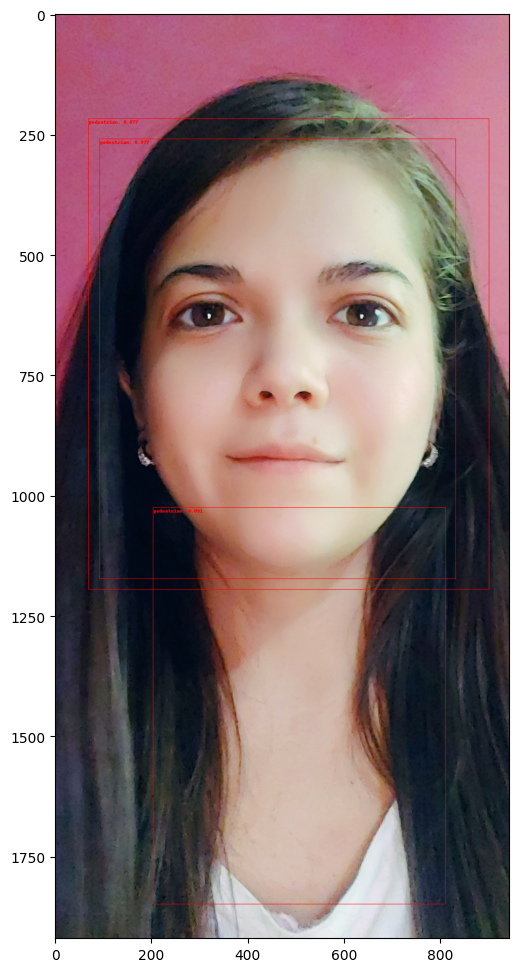

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(os.path.join(female_path, "f1_tr_103.jpg"))
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"man: {score:.3f}" if label == 1 else f"woman: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
pred

{'boxes': tensor([[1523.8590,  965.8042, 2970.2300, 2347.4548],
         [1429.2546,  953.6129, 3022.6990, 2402.8457]], device='cuda:0'),
 'labels': tensor([2, 1], device='cuda:0'),
 'scores': tensor([0.8190, 0.3914], device='cuda:0')}